<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Visión Computacional </em><br>
    <em>Profesor: Takeshi Asahi </em><br>

</div>

# Machine Learning Avanzado
*22 de Abril de 2024*

#### Integrantes: 
` Giuseppe Lavarello`

## 1. Objetivo

El objetivo principal de esta tarea consiste en implementar un programa en Python para preprocesar imágenes.

Para lograrlo, se trabajará el conjunto de datos **Brain Tumor MRI Dataset**, disponible en **Kaggle**.

1.  Se eligió este dataset por su relevancia en el tratamiento de pacientes con tumores cerebrales. Esto es un probrema importante pues la identificación de los tumores facilita la determinación del tratamiento con mayor probabilidades de éxito.
2.  El propósito es identificar los tipos de tumores presentes en las imágenes obtenidas mediante resonancia magnética, entre:  tumores pituitarios, gliomas, meningiomas o la ausencia de tumor.
3.  En este notebook en particular, se llevará a cabo únicamente el preprocesamiento básico de las imágenes.


# 2. Carga de datos

In [622]:
import os
from PIL import Image
from PIL import ImageFilter
import random
import matplotlib.pyplot as plt



def cargar_imagenes(directorio_principal, num_imagenes=40):
    imagenes_cargadas = {}
    subcarpetas = [d for d in os.listdir(directorio_principal) if os.path.isdir(os.path.join(directorio_principal, d))]

    for subcarpeta in subcarpetas:
        ruta_subcarpeta = os.path.join(directorio_principal, subcarpeta)
        nombres_archivos = [f for f in os.listdir(ruta_subcarpeta) if os.path.isfile(os.path.join(ruta_subcarpeta, f))]
        # Filtrar por archivos de imagen (son todos jpg)
        nombres_imagenes = [f for f in nombres_archivos if f.lower().endswith(('.jpg', '.jpeg'))]
        # Tomar un subconjunto aleatorio de imágenes
        imagenes_seleccionadas = random.sample(nombres_imagenes, num_imagenes)
        lista_imagenes = []
        # Cargar las imágenes seleccionadas y añadirlas a la lista
        for nombre_imagen in imagenes_seleccionadas:
            ruta_imagen = os.path.join(ruta_subcarpeta, nombre_imagen)
            imagen = Image.open(ruta_imagen)
            lista_imagenes.append((imagen, nombre_imagen))


        imagenes_cargadas[subcarpeta] = lista_imagenes

    return imagenes_cargadas




In [623]:
def mostrar_imagen(imagen, nombre_imagen='', titulo=f"Imagen", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    if imagen.mode == 'L':
        ax.imshow(imagen, cmap='gray')
    else:
        ax.imshow(imagen)
    ax.set_title(f"{titulo}")
    ax.axis('off')
    if ax is None:
        plt.show()

El dataset consiste en 2 grupos de imágenes separados en entrenamiento y testeo. A su vez, cada grupo está organizado en subcarpetas según las siguientes etiquetas:
- glioma
- meningioma
- notumor
- pituitary

El recuento total de imágenes por diagnóstico es:
- 1621 imágenes de MRI con diagnóstico de Glioma
- 1645 imágenes con diagnóstico de Meningioma
- 2000 imágenes sin tumor
- 1757 imágenes con tumor pituitario

Se observa que la cantidad de imágenes por categoría está bastante balanceada, con una ligera sobre representación de las imágenes sin tumor.

In [624]:
# Ruta a las carpetas de entrenamiento 
ruta_training = r'./data/Training'
ruta_testing = r'./data/testing'
# chequear el numero de elementros en cada carpeta
for carpeta in os.listdir(ruta_training):
    print(f"{carpeta}, Número de imágenes: {len(os.listdir(os.path.join(ruta_training, carpeta)))}")
print("\n")    
for carpeta in os.listdir(ruta_testing):
    print(f"{carpeta}, Número de imágenes: {len(os.listdir(os.path.join(ruta_testing, carpeta)))}")

glioma, Número de imágenes: 1321
meningioma, Número de imágenes: 1339
notumor, Número de imágenes: 1595
pituitary, Número de imágenes: 1457


glioma, Número de imágenes: 300
meningioma, Número de imágenes: 306
notumor, Número de imágenes: 405
pituitary, Número de imágenes: 300


**Decisión** Dado que se está preparando la data para futuras tareas, solo se preprocesará la data de entrenamiento. En el futuro, se procesará toda la data utilizada para entrenar el modelo.

In [625]:

# Carga el subset de imágenes para la carpeta 'training'
subset_training = cargar_imagenes(ruta_training, num_imagenes=40)
print("Imágenes cargadas del directorio 'training':")
for tipo_tumor, lista in subset_training.items():
    print(f"- {tipo_tumor}: {len(lista)} imágenes")

Imágenes cargadas del directorio 'training':
- glioma: 40 imágenes
- meningioma: 40 imágenes
- notumor: 40 imágenes
- pituitary: 40 imágenes


# 3. Preprocesamiento de datos
## 3.1 RGB vs. Escala de Grises

Una inspección rapida muestra que la una gran parte de las imágenes están en formato de escala de grises, pero otras están en formato RGB.

**Decisión:** Se convertirán todas las imágenes a escala de grises.

(Existen algunos casos donde hay imagenes RGB-A estas son tratadas de la misma manera que las RGB)

{'L': 61, 'RGB': 99}


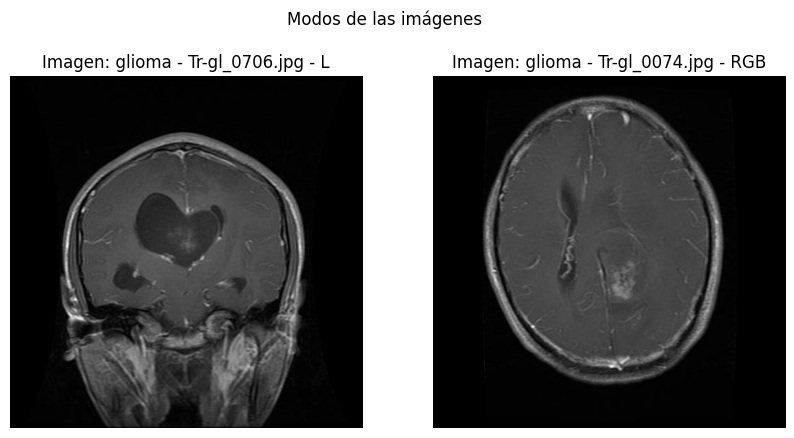

In [648]:
def get_image_modes_and_counts(imagenes):
    modos = set()
    for tipo_tumor, lista_imagenes in imagenes.items():
        for imagen, nombre in lista_imagenes:
            modo = imagen.mode
            modos.add(modo)
    fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=len(modos), squeeze=False)
    fig.suptitle("Modos de las imágenes")
    axs = axs.flatten()
    modos = {}
    i = 0
    for tipo_tumor, lista_imagenes in imagenes.items():
        for imagen, nombre in lista_imagenes:
            modo = imagen.mode
            if modo not in modos:
                modos[modo] = 0
                mostrar_imagen(imagen, nombre_imagen=nombre, titulo=f"Imagen: {tipo_tumor} - {nombre} - {modo}", ax=axs[i])
                i += 1
            modos[modo] += 1

    print(modos)

get_image_modes_and_counts(subset_training)

**Importante** Al convertir la imagen a escala de grices se perderá información, dado que reducimos las dimensiones del problema final. una posible solucion es filtrar todas las imagenes y quedarnos solo con las RGB, esta desición se reevaluara en el futuro.

In [627]:
def convertir_grayscale(imagenes):
    imagenes_grayscale = {}
    ej=0
    for tipo_tumor, lista in imagenes.items():
        lista_grayscale = []
        for i, (imagen, nombre) in enumerate(lista):
            if imagen.mode != 'L':
                imagen_grayscale = imagen.convert("L") # Convertir a escala de grises
                if not ej: ej=i
            imagen_grayscale = imagen 
            lista_grayscale.append((imagen_grayscale, nombre)) # Añadir la imagen convertida a la lista
        imagenes_grayscale[tipo_tumor] = lista_grayscale
    return imagenes_grayscale, ej

In [628]:

subset_training_grey, ej = convertir_grayscale(subset_training)


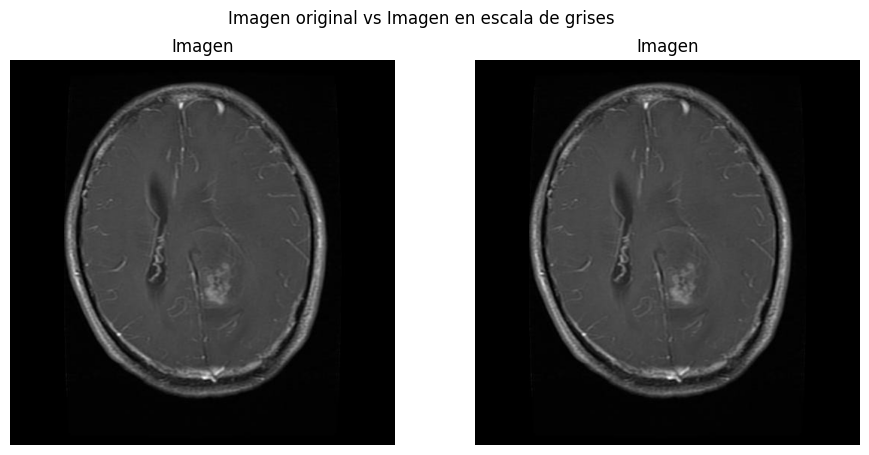

In [647]:
fig, axs = plt.subplots(figsize=(11, 5), nrows=1, ncols=2, squeeze=False)
fig.suptitle("Imagen original vs Imagen en escala de grises")
axs = axs.flatten()
mostrar_imagen(*subset_training['glioma'][ej], ax=axs[0])
mostrar_imagen(*subset_training_grey['glioma'][ej], ax=axs[1])

## 3.2 Ajuste de tamaño

Se realiza un ajuste de tamaño para minimizar la cantidad de recursos que se utilizarán al entrenar el modelo. Si bien se pierde información al realizar este proceso, es importante tomar en cuenta los recursos disponibles, y el tiempo que se le puede entregar al entrenamiento.

In [630]:
def resize_imagenes(imagenes, nuevo_tamano=(256, 256)):
    imagenes_redimensionadas = {}
    for tipo_tumor, lista in imagenes.items():
        lista_redimensionada = []
        for imagen, nombre in lista:
            imagen_redimensionada = imagen.resize(nuevo_tamano) # Redimensionar la imagen mediante PIL
            lista_redimensionada.append((imagen_redimensionada, nombre)) # Añadir imagen nueva y redimensionada a la lista
        imagenes_redimensionadas[tipo_tumor] = lista_redimensionada
    return imagenes_redimensionadas

In [631]:
subset_training_256 = resize_imagenes(subset_training_grey, nuevo_tamano=(256, 256)) #entrada de 256x256

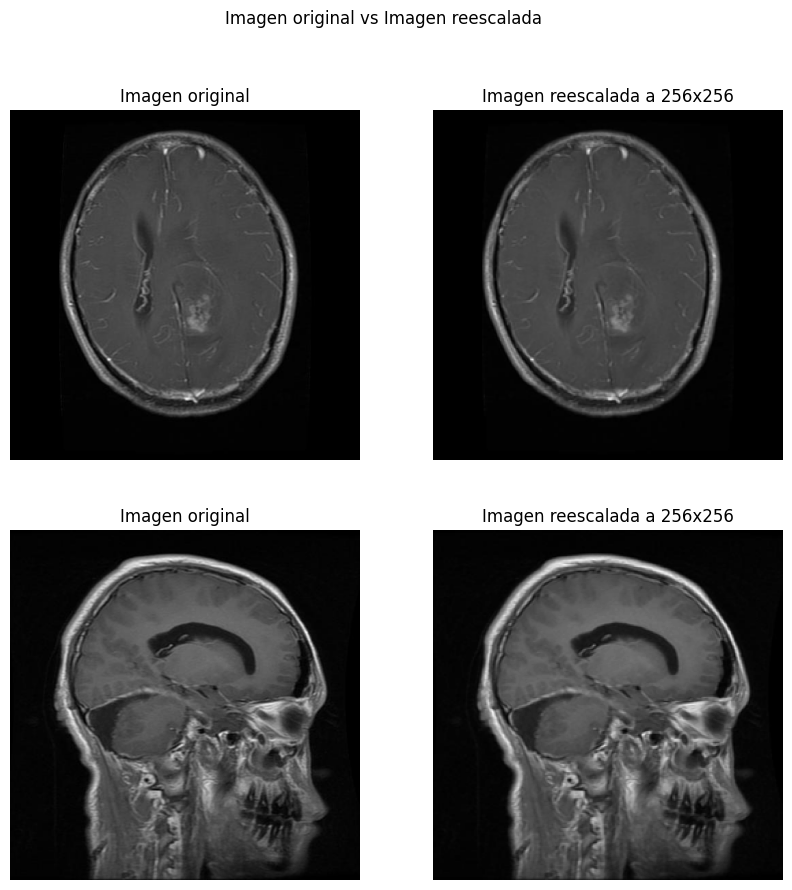

In [646]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2, squeeze=True)
fig.suptitle("Imagen original vs Imagen reescalada")
axs = axs.flatten()
mostrar_imagen(*subset_training_grey['glioma'][ej], titulo="Imagen original",ax=axs[0])
mostrar_imagen(*subset_training_256['glioma'][ej], titulo="Imagen reescalada a 256x256",ax=axs[1])
mostrar_imagen(*subset_training_grey['glioma'][ej+1], titulo="Imagen original",ax=axs[2])
mostrar_imagen(*subset_training_256['glioma'][ej+1], titulo="Imagen reescalada a 256x256",ax=axs[3])

In [633]:
def exportar_carpetas(imagenes, directorio_salida):
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)

    for tipo_tumor, lista in imagenes.items():
        ruta_tipo_tumor = os.path.join(directorio_salida, tipo_tumor)
        if not os.path.exists(ruta_tipo_tumor):
            os.makedirs(ruta_tipo_tumor)

        for imagen, nombre in lista:
            ruta_imagen = os.path.join(ruta_tipo_tumor, nombre)
            imagen.save(ruta_imagen)

In [634]:
exportar_carpetas(subset_training_256, './data/Training_L_256x256')


# 4. Aplicación de filtro a las imágenes

Se aplica un flitro gaussiano a la imagen para reducir el efecto del ruido sobre el modelo. 

In [635]:
def filtro_gaussiano(image_set, sigma=1.0):
    imagen_fitrada = {}
    for tipo_tumor, lista in image_set.items():
        lista_filtrada = []
        for imagen, nombre in lista:
            filtrada = imagen.filter(ImageFilter.GaussianBlur(radius=sigma)) # Aplicar el filtro gaussiano mediante PIL
            lista_filtrada.append((filtrada, nombre))
        imagen_fitrada[tipo_tumor] = lista_filtrada 
    return imagen_fitrada

In [636]:
subset_training_gaussiano = filtro_gaussiano(subset_training, sigma=1.0)

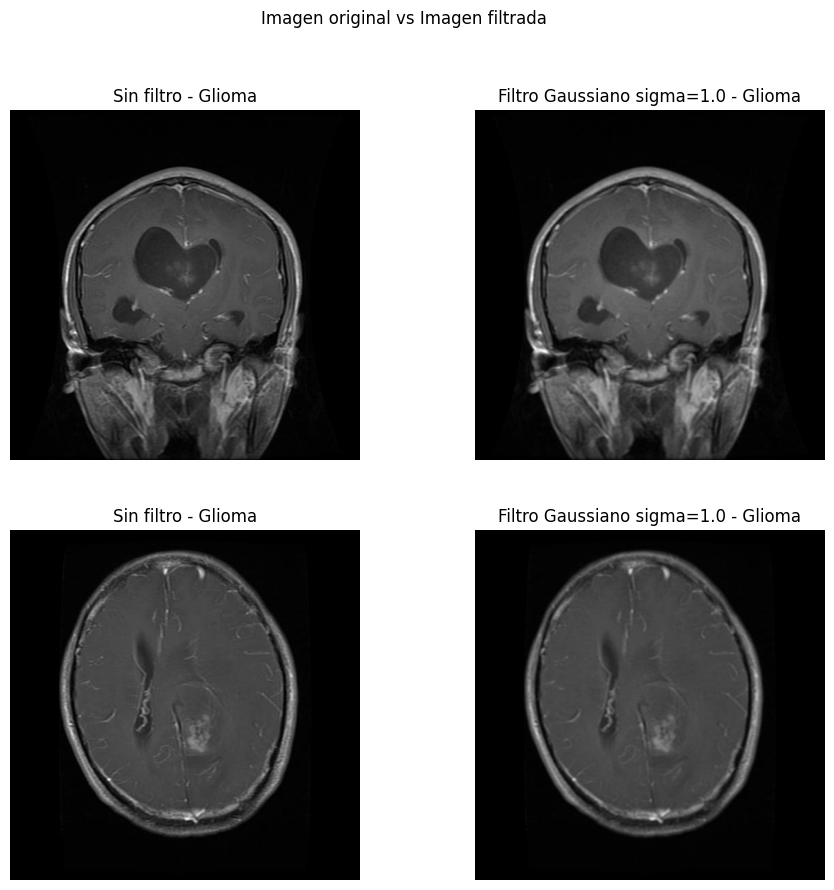

In [654]:
fig, axs = plt.subplots(figsize=(11, 10), nrows=2, ncols=2, squeeze=False)
fig.suptitle("Imagen original vs Imagen filtrada")
axs = axs.flatten()
mostrar_imagen(*subset_training_gaussiano['glioma'][0], titulo="Filtro Gaussiano sigma=1.0 - Glioma", ax=axs[1])
mostrar_imagen(*subset_training_grey['glioma'][0], titulo="Sin filtro - Glioma", ax=axs[0])
mostrar_imagen(*subset_training_gaussiano['glioma'][ej], titulo="Filtro Gaussiano sigma=1.0 - Glioma", ax=axs[3])
mostrar_imagen(*subset_training_grey['glioma'][ej], titulo="Sin filtro - Glioma", ax=axs[2])

In [638]:
exportar_carpetas(subset_training_gaussiano, './data/Training_L_Gaussian')